In [1]:
import pathlib
import pylab as plt

import os
import re
import itertools  
import numpy as np
from numpy import unique
from numpy import where
import pandas as pd
import matplotlib
import seaborn as sns
import sys
import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set_style('white')

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [168]:
PRJ='PRJNA747757'
BASE_PATH='/mnt/8TB_1/Data/genbank/'
DATA_PATH=f'{BASE_PATH}{PRJ}/'
PLOT_PATH=f'/mnt/8TB_2/Data/Assembly/{PRJ}/general_plots/'
PLOT_DATA_FILE='Runs.csv'
DATA_EXT='_ncbi_mt_minimap2_coverage.txt'
TAXA = '/mnt/1TB_0/Data/fasta/mitochondria/ncbi_mt_20220505.taxa'
ITERATION=0
PARAMS='sr'
COVERAGE=50
ABS_MIN_COV=10

In [169]:
df_run=pd.read_csv(PLOT_PATH+PLOT_DATA_FILE)
host=df_run['ScientificName'].tolist()
host_summs=[]
for h in host:
    name=h.split()
    if len(name)==1:
        host_summ=h[:5]
    elif len(name)==2:
        host_summ_1=name[0]
        host_summ_2=name[1]
        host_summ=host_summ_1[:5]+' '+host_summ_2[:2]
    else:  
        host_summ_1=name[0]
        host_summ_2=name[1]
        host_summ_3=name[2]
        host_summ=host_summ_1[:5]+' '+host_summ_2[:2]
        host_summ=host_summ+' '+host_summ_3[:2]
    host_summs.append(host_summ)
df_run['host_summ']=host_summs
df_run.shape

(29, 53)

In [170]:
def read_taxa():
    f = open(TAXA,"r")
    lines = f.readlines()
    ascs=[]
    descrs=[]
    for line in lines:
        asc=line.split()[0]
        descr=line.split(None,1)[1]
        descr=descr.rstrip()
        ascs.append(asc)
        descrs.append(descr)
    return ascs, descrs

In [171]:
def match_runs(sras, df_run):
    run_name=df_run['SampleName'].tolist()
    run_SRA=df_run['Run'].tolist()
    run_host=df_run['ScientificName'].tolist()
    run_host_summ=df_run['host_summ'].tolist()
    print(f'run name: {run_name[:2]} {len(run_name)}')
    print(f'run_SRA: {run_SRA[:2]} {len(run_SRA)}')
    print(f'run_host: {run_host[:2]} {len(run_host)}')
    print(f'run_host_summ: {run_host_summ[:2]} {len(run_host_summ)}')
    host_summs=[]
    names=[]
    hosts=[]
    n=0
    for sra in sras:
        if (n % 100==0):
            print(sra)
            print(run_SRA.index(sra.strip()))
        idx=run_SRA.index(sra.strip())
        name=run_name[idx]
        host=run_host[idx]
        host_summ=run_host_summ[idx]
        names.append(name)
        hosts.append(host)
        host_summs.append(host_summ)
        n+=1
    return names, hosts, host_summs

In [172]:
def match_ascession(ascessions, taxa_asc, taxa_descr):
    descrs=[]
    for asc in ascessions:
        try:
            idx=taxa_asc.index(asc.strip())
            descr=taxa_descr[idx]
            descrs.append(descr)
        except ValueError as e:
            print(f'Error with: {asc}')
            t=!blastdbcmd -db nt -entry asc.strip()
            print(f'{t}')
            if 'Entry not found:' in t[0]:
                descrs.append('Entry not found:')
                print(f'Entry not found: {asc}')
            else:
                descr=t[0].split(' ', 1)[1]
                descrs.append(descr)
    return descrs

In [173]:
def get_num_reads(sra):
    f = open(DATA_PATH+'fastp/'+sra+'_fastp.json',"r")
    lines = f.readlines()
    ascs=[]
    descrs=[]
    hit=False
    reads=0
    for line in lines:
        if '"after_filtering":' in line:
            hit=True
        if '"total_reads":' in line:
            if hit:
                reads=line.split(':')[1]
                reads = re.sub('[^0-9]','', reads)
                reads=int(reads.split()[0])
                hit=False
    return reads

In [174]:
def parse_mt_files():
    #if coverage calculated on viral file not mt, then re-run coverage 
    all_files = os.listdir(DATA_PATH)
    coverage_files = [f for f in all_files if f.endswith(".txt")]
    coverage_files = [f for f in coverage_files if DATA_EXT in f]
    coverage_files = [f for f in coverage_files if '~lock' not in f]
    frames=[]
    for f in coverage_files:
        print(f)
        try:
            df = pd.read_csv(DATA_PATH+f, header = 0, sep='\t')
            ascessions = df['#rname']
            #if 'NC_045512.2' in ascessions.tolist():
            #    srr= f.split('_',1)[0]
            #    #print(df.head(n=2))
            #    print(f'running samtools coverage on {srr}')
            #    !samtools coverage {DATA_PATH}{srr}_ncbi_mt_minimap2_sorted.bam -o {DATA_PATH}{srr}_ncbi_mt_minimap2_coverage.txt
        except Exception as e:
            pass
            #print(f'{f} {str(e)}')

In [175]:
def expand_fields(df_all):
    sras=df_all['Run']
    sras=list(set(sras))
    names, hosts, host_summs = match_runs(sras, df_run)
    df_all['SampleName'] = names
    sample_name_species=list(map(" ".join, itertools.product(names, host_summs)))
    print(len(sample_name_species))
    print(sample_name_species[:10])
    print(len(hosts))
    #df_all['sample_name_species'] = sample_name_species
    #df_all['host'] = hosts
    return df_all

In [176]:
def read_coverage(df_run, taxa_asc, taxa_descr, truncate_at_min=True):
    all_files = os.listdir(DATA_PATH)
    coverage_files = [f for f in all_files if f.endswith(".txt")]
    coverage_files = [f for f in coverage_files if DATA_EXT in f]
    coverage_files = [f for f in coverage_files if '~lock' not in f]
    frames=[]
    
    for f in coverage_files:
        try:
            df = pd.read_csv(DATA_PATH+f, header = 0, sep='\t')
            df = df.sort_values(by=['coverage','numreads'], ascending=False)
            if truncate_at_min:
                df = df[df['coverage'] >= ABS_MIN_COV] 
            ascessions = df['#rname']
            
            try:
                descrs=match_ascession(ascessions, taxa_asc, taxa_descr)
                df['description']=descrs
                srr= f.split('_',1)[0]
                df['SRA']=[srr]*len(df)
                sample_name=df_run.loc[df_run['Run'] == srr, 'SampleName'].tolist()[0]
                df['SampleName']=[sample_name]*len(df)
                #numreads
                df['total_reads']=get_num_reads(srr)*len(df)
                tot_mt_reads=df['numreads'].sum()
                df['mt_reads']=[tot_mt_reads]*len(df)
                df['pct_mt']=(df['numreads']/tot_mt_reads)*100
                #keep only highest mt coverage where have duplicates
                df=df.drop_duplicates(subset='description', keep="first")
                frames.append(df)
            except KeyError as e:
                print(f'KeyError error with {f}')
        except Exception as e:
            print(f'{str(e)} error with {f}')
    df_all=pd.concat(frames)
    return df_all

In [177]:
#parse_mt_files()

In [178]:
taxa_asc, taxa_descr = read_taxa()

### read/write section

In [179]:
df_all = read_coverage(df_run, taxa_asc, taxa_descr)

In [180]:
df_all.to_csv(PLOT_PATH+'runs_preprocessed.csv')

In [181]:
#df_all=pd.read_csv(PLOT_PATH+'runs_preprocessed.csv')

In [182]:
#df_all.drop(['Unnamed: 0'], axis=1, inplace=True)
df_all.head()

,#rname,startpos,endpos,numreads,covbases,coverage,meandepth,meanbaseq,meanmapq,description,SRA,SampleName,total_reads,mt_reads,pct_mt
999,NC_028310.1,1,16640,18957591,16640,100.0000,85793.300,33.5,11.200,Felis silvestris,SRR15199664,CT_HT,100549578824,56286991.0,33.680235
4075,NC_001700.1,1,17009,25203916,16872,99.1945,98264.200,33.5,20.000,Felis catus,SRR15199664,CT_HT,100549578824,56286991.0,44.777515
997,NC_028308.1,1,16864,8574596,16560,98.1973,38036.700,33.6,5.380,Felis margarita,SRR15199664,CT_HT,100549578824,56286991.0,15.233708
5759,NC_016008.1,1,16578,5074,12106,73.0245,29.342,33.9,21.500,Manis pentadactyla,SRR15199664,CT_HT,100549578824,56286991.0,0.009015
998,NC_028309.1,1,16723,205235,12087,72.2777,1099.370,33.3,0.494,Felis nigripes,SRR15199664,CT_HT,100549578824,56286991.0,0.364622


In [183]:
#df_all=expand_fields(df_all)

In [184]:
df_all.nunique()

#rname          279
startpos          1
endpos          215
numreads       1177
covbases       1127
coverage       1242
meandepth      1254
meanbaseq        53
meanmapq        923
description     269
SRA              24
SampleName       24
total_reads      24
mt_reads         24
pct_mt         1243
dtype: int64

In [185]:
### filter to => 10%
df_all = df_all.loc[df_all['coverage'] >=COVERAGE]

In [186]:
df_all.description=df_all.description.str.replace(' mitochondrion, complete genome', '')
df_all.description=df_all.description.str.replace(' mitochondrial DNA, complete sequence', '')
df_all.description=df_all.description.str.replace(' mitochondrial DNA, complete genome', '')

In [187]:
df_all.head()

,#rname,startpos,endpos,numreads,covbases,coverage,meandepth,meanbaseq,meanmapq,description,SRA,SampleName,total_reads,mt_reads,pct_mt
999,NC_028310.1,1,16640,18957591,16640,100.0000,85793.300,33.5,11.200,Felis silvestris,SRR15199664,CT_HT,100549578824,56286991.0,33.680235
4075,NC_001700.1,1,17009,25203916,16872,99.1945,98264.200,33.5,20.000,Felis catus,SRR15199664,CT_HT,100549578824,56286991.0,44.777515
997,NC_028308.1,1,16864,8574596,16560,98.1973,38036.700,33.6,5.380,Felis margarita,SRR15199664,CT_HT,100549578824,56286991.0,15.233708
5759,NC_016008.1,1,16578,5074,12106,73.0245,29.342,33.9,21.500,Manis pentadactyla,SRR15199664,CT_HT,100549578824,56286991.0,0.009015
998,NC_028309.1,1,16723,205235,12087,72.2777,1099.370,33.3,0.494,Felis nigripes,SRR15199664,CT_HT,100549578824,56286991.0,0.364622


In [188]:
df_pivot=df_all.pivot_table(index='SampleName', columns='description', values='coverage')

In [189]:
df_pivot.head()

description,Anser albifrons,Anser anser,Anser cygnoides,Anser indicus,Branta canadensis,Cairina moschata,Canis anthus,Canis latrans,Canis lupus,Canis rufus,...,Panthera onca,Panthera pardus,Panthera tigris,Pipistrellus abramus,Prionailurus planiceps,Prionailurus rubiginosus,Puma concolor,Sus scrofa,Uncia uncia,Vicugna vicugna
SampleName,,,,,,,,,,,,,,,,,,,,,
CT_ED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,61.0266,NaN,NaN,NaN,NaN
CT_ES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,50.8289,54.9608,NaN,NaN,NaN,NaN
CT_HT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,55.9173,NaN,NaN,NaN,NaN
CT_KY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,53.9649,61.8465,51.2272,NaN,NaN,NaN
CT_LG,58.6784,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [190]:
def get_samples(y_labels, df_datasets):
    y_names=[]
    for sra in y_labels:
        y_names.append(df_run.loc[df_run['SRA'] == sra.strip(), 'Sample Name'].values[0])
        y_hosts.append(df_run.loc[df_run['SRA'] == sra.strip(), 'HOST'].values[0])
    return y_names, y_hosts

In [191]:
def get_accessions(x_labels, df_accessions):
    x_codes=[]
    for accession in x_labels:
        x_codes.append(df_accessions.loc[df_accessions['Accession'] == accession.strip(), 'Code'].values[0])
    return x_codes

In [192]:
df_pivot_t=df_pivot.T
data=df_pivot_t.to_numpy()

y_labels=df_pivot_t.index.tolist()
x_labels=list(df_pivot_t.columns.values)

In [193]:
df_pivot.head()

description,Anser albifrons,Anser anser,Anser cygnoides,Anser indicus,Branta canadensis,Cairina moschata,Canis anthus,Canis latrans,Canis lupus,Canis rufus,...,Panthera onca,Panthera pardus,Panthera tigris,Pipistrellus abramus,Prionailurus planiceps,Prionailurus rubiginosus,Puma concolor,Sus scrofa,Uncia uncia,Vicugna vicugna
SampleName,,,,,,,,,,,,,,,,,,,,,
CT_ED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,61.0266,NaN,NaN,NaN,NaN
CT_ES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,50.8289,54.9608,NaN,NaN,NaN,NaN
CT_HT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,55.9173,NaN,NaN,NaN,NaN
CT_KY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,53.9649,61.8465,51.2272,NaN,NaN,NaN
CT_LG,58.6784,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [194]:
y_names=y_labels
x_codes=x_labels

In [195]:
plot_data = np.ma.masked_equal(data[:,:], 0)

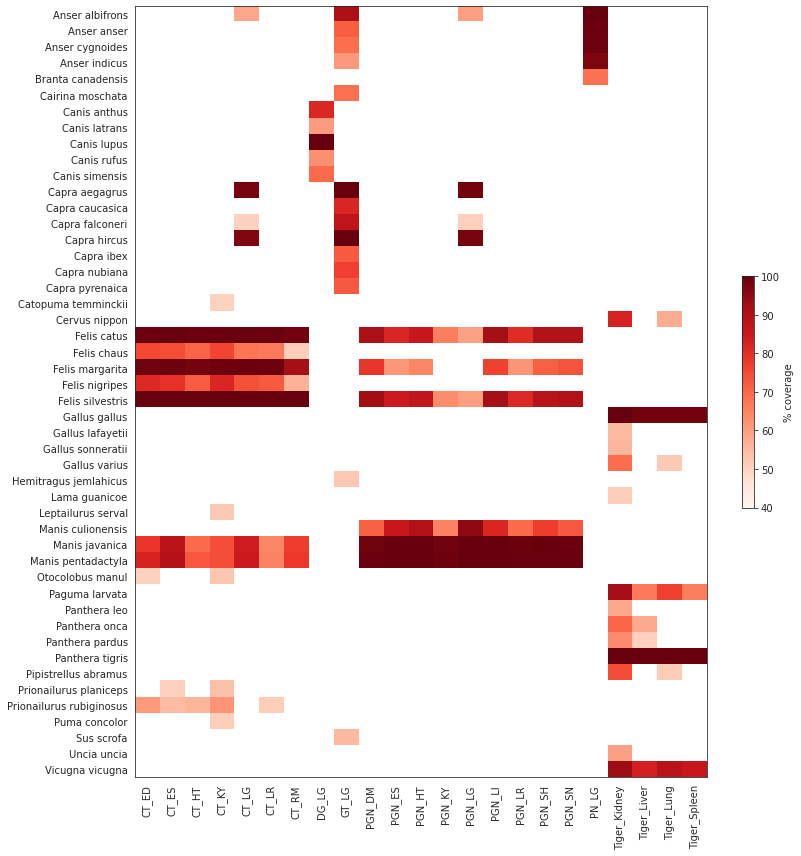

In [199]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(12,12))
#img=ax.imshow(plot_data, cmap=plt.cm.get_cmap("Reds"), interpolation="nearest", aspect='auto',norm=matplotlib.colors.LogNorm())
img=ax.imshow(plot_data, cmap=plt.cm.get_cmap("Reds"), interpolation="nearest", aspect='auto', vmin = 40, vmax = 100) 

ax.set_xticks(list(range(len(x_codes))))
ax.set_xticklabels(x_codes,rotation=90)
ax.set_yticks(list(range(len(y_names))))
ax.set_yticklabels(y_names)

cbar=fig.colorbar(img, label='% coverage', shrink=0.3)

plt.tight_layout()
fig.savefig(PLOT_PATH+f"Mt_{PARAMS}_sample_name_{COVERAGE}pct_V2.png", bbox_inches='tight')

## Percent


In [200]:
### filter to => N%
df_frac = df_all.loc[df_all['coverage'] >=COVERAGE]

In [201]:
total_mt_count = df_frac['mt_reads'].sum()
df_frac['total_cut_mt_reads'] = total_mt_count
df_frac['cut_frac_mt'] = df_frac['mt_reads'].div(total_mt_count).round(4)
df_frac['cut_frac_pct'] = df_frac['cut_frac_mt']*100

In [202]:
df_frac.description=df_frac.description.str.replace(' mitochondrion, complete genome', '')
df_frac.description=df_frac.description.str.replace(' mitochondrial DNA, complete sequence', '')
df_frac.description=df_frac.description.str.replace(' mitochondrial DNA, complete genome', '')

In [203]:
#df_frac=df_frac.pivot_table(index='sample_name', columns='description', values='cut_frac_pct')
#df_frac.shape

In [204]:
df_frac=df_frac.pivot_table(index='SampleName', columns='description', values='pct_mt')
df_frac.shape

(23, 48)

In [205]:
df_frac=df_frac.T
data=df_frac.to_numpy()

y_labels=df_frac.index.tolist()
x_labels=list(df_frac.columns.values)
y_names=y_labels
x_codes=x_labels
plot_data = np.ma.masked_equal(data[:,:], 0)

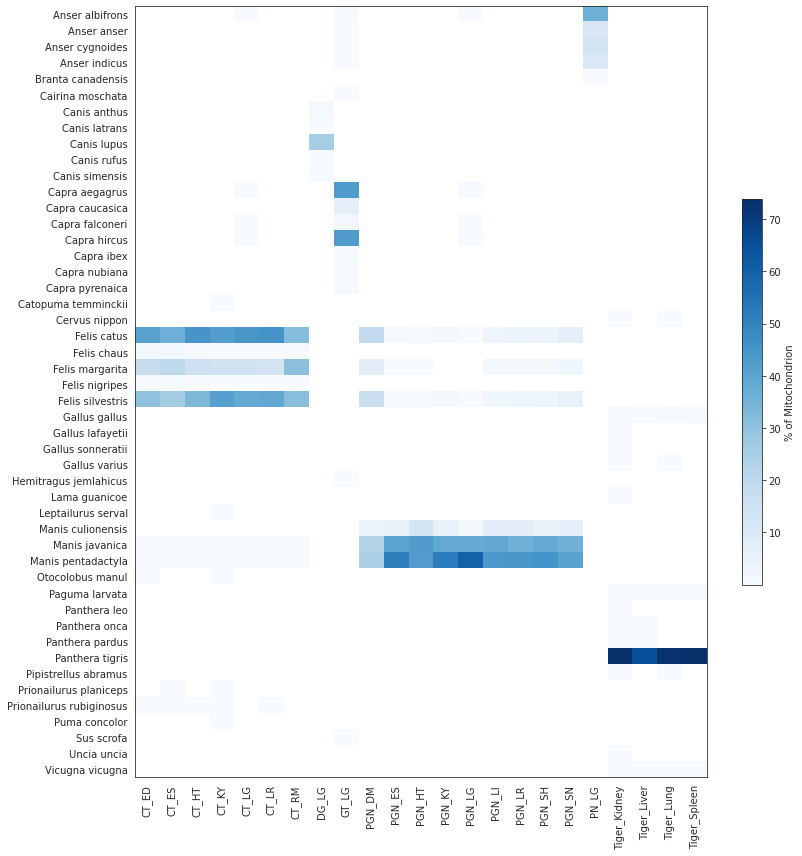

In [207]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(12,12))
#img=ax.imshow(plot_data, cmap=plt.cm.get_cmap("Blues"), interpolation="nearest", aspect='auto', \
#              norm=matplotlib.colors.LogNorm(), vmin = 10, vmax = 100)
img=ax.imshow(plot_data, cmap=plt.cm.get_cmap("Blues"), interpolation="nearest", aspect='auto')

ax.set_xticks(list(range(len(x_codes))))
ax.set_xticklabels(x_codes,rotation=90)
ax.set_yticks(list(range(len(y_names))))
ax.set_yticklabels(y_names)


cbar=fig.colorbar(img, label='% of Mitochondrion', shrink=0.5)

plt.tight_layout()
fig.savefig(PLOT_PATH+f"Mt_{PARAMS}_fraction_of_Mt_{COVERAGE}_log_V2.png", bbox_inches='tight')